In [1]:
%matplotlib inline

import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt
from gammapy.data import Observation, FixedPointingInfo, observatory_locations
from gammapy.datasets import MapDataset, FluxPointsDataset
from gammapy.irf import load_irf_dict_from_file
from gammapy.makers import MapDatasetMaker, SafeMaskMaker
from gammapy.maps import MapAxis, WcsGeom
from gammapy.modeling import Fit
from gammapy.modeling.models import (
    SkyModel,
    GaussianSpatialModel,
    ExpCutoffPowerLawSpectralModel,
    FoVBackgroundModel,
    Models,
    UniformPrior,
    LogUniformPrior,
)
from gammapy.modeling.sampler import Sampler
from ultranest.plot import cornerplot
from gammapy.estimators import FluxPointsEstimator

def create_simulation():
    """Creates a 3D simulation of a Gaussian source."""
    
    # 1. Load IRFs
    irf_filename = "/Users/facero/Documents/Work/CTA/IRFs/cta-prod5-zenodo-fitsonly-v0.1/fits/CTA-Performance-prod5-v0.1-South-20deg.FITS/Prod5-South-20deg-AverageAz-14MSTs37SSTs.18000s-v0.1.fits.gz"
    print(f"Loading IRFs from: {irf_filename}")
    irfs = load_irf_dict_from_file(irf_filename)

    # 2. Define Models
    # Spatial: Gaussian
    spatial_model = GaussianSpatialModel(
        lon_0="0.0 deg", lat_0="0.0 deg", sigma="0.2 deg", frame="galactic"
    )
    
    # Spectral: Exponential Cutoff Powerlaw
    spectral_model = ExpCutoffPowerLawSpectralModel(
        index=1.5,
        amplitude="5e-13 cm-2 s-1 TeV-1",
        reference="1 TeV",
        lambda_="0.05 TeV-1",
        alpha=1.0,
    )
    
    model_simu = SkyModel(
        spatial_model=spatial_model,
        spectral_model=spectral_model,
        name="model-simu",
    )
    
    bkg_model = FoVBackgroundModel(dataset_name="dataset-simu")
    
    models = Models([model_simu, bkg_model])
    
    # 3. Define Geometry
    # Energy axis for reconstruction
    energy_reco = MapAxis.from_edges(
        np.logspace(-1.0, 2.0, 10), unit="TeV", name="energy", interp="log"
    )
    
    # Spatial geometry
    geom = WcsGeom.create(
        skydir=(0, 0),
        binsz=0.02,
        width=(6, 6),
        frame="galactic",
        axes=[energy_reco],
    )
    
    # Energy axis for true energy (simulation)
    energy_true = MapAxis.from_edges(
        np.logspace(-1.5, 2.5, 30), unit="TeV", name="energy_true", interp="log"
    )
    
    # 4. Create Empty Dataset
    empty = MapDataset.create(geom, name="dataset-simu", energy_axis_true=energy_true)
    
    # 5. Create Observation
    pointing = FixedPointingInfo(
        fixed_icrs=SkyCoord(0, 0, unit="deg", frame="galactic").icrs,
    )
    location = observatory_locations["ctao_south"]
    livetime = 20.0 * u.hr # Arbitrary livetime, user didn't specify
    
    obs = Observation.create(
        pointing=pointing, livetime=livetime, irfs=irfs, location=location
    )
    
    # 6. Make MapDataset
    maker = MapDatasetMaker(selection=["exposure", "background", "psf", "edisp"])
    maker_safe_mask = SafeMaskMaker(methods=["offset-max"], offset_max=4.0 * u.deg)
    
    dataset = maker.run(empty, obs)
    dataset = maker_safe_mask.run(dataset, obs)
    
    # 7. Fake the data
    dataset.models = models
    dataset.fake()
    
    return dataset, model_simu

def compute_flux_points(dataset):
    """Computes flux points from the dataset."""
    energy_edges = np.logspace(-1, 2, 8) * u.TeV
    
    fpe = FluxPointsEstimator(
        energy_edges=energy_edges, 
        source="model-simu", 
        selection_optional=["ul"]
    )
    flux_points = fpe.run(datasets=[dataset])
    return flux_points

def fit_3d_dataset(dataset, model_init):
    """Fits the 3D dataset."""
    # Clone model to avoid modifying the ground truth
    model_copy = model_init.copy()
    model_simu_fit = SkyModel(
        spatial_model=model_copy.spatial_model,
        spectral_model=model_copy.spectral_model,
        name="model-simu"
    )
    
    # Get background model from dataset
    bkg_model = dataset.models["dataset-simu-bkg"]
    
    models_fit = Models([model_simu_fit, bkg_model])
    
    # Freeze background
    models_fit["dataset-simu-bkg"].spectral_model.norm.frozen = False
    models_fit["dataset-simu-bkg"].spectral_model.tilt.frozen = True
    models_fit["model-simu"].spectral_model.alpha.frozen = True
    models_fit["model-simu"].spatial_model.lon_0.frozen = True
    models_fit["model-simu"].spatial_model.lat_0.frozen = True
    models_fit["model-simu"].spatial_model.sigma.frozen = True
    
    dataset.models = models_fit
    print("Models for 3D fit:", models_fit)
    
    fit = Fit()
    result = fit.run(datasets=[dataset])
    
    return result, models_fit["model-simu"]

def fit_flux_points(flux_points, model_init, stat_type='distrib'):
    """Fits the flux points."""
    # Create FluxPointsDataset
    fp_dataset = FluxPointsDataset(data=flux_points, name="flux-points-dataset",stat_type=stat_type)
    
    # Set model
    model_copy = model_init.copy()
    model_fit = SkyModel(
        spatial_model=model_copy.spatial_model,
        spectral_model=model_copy.spectral_model,
        name="model-fit-fp"
    )
    fp_dataset.models = [model_fit]
    
    fit = Fit()
    result = fit.run(datasets=[fp_dataset])
    
    return result, model_fit

def plot_diagnostics(truth_model, model_3d, model_fp):
    """Plots diagnostic comparison of parameters."""
    
    params = ["amplitude", "index", "lambda_"]
    
    values_truth = [truth_model.spectral_model.parameters[p].value for p in params]
    values_3d = [model_3d.spectral_model.parameters[p].value for p in params]
    values_fp = [model_fp.spectral_model.parameters[p].value for p in params]
    
    errors_3d = [model_3d.spectral_model.parameters[p].error for p in params]
    errors_fp = [model_fp.spectral_model.parameters[p].error for p in params]
    
    # Normalize amplitude for plotting (it's usually very small)
    # Actually, let's plot relative difference or just values with subplots
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    labels = ["Truth", "3D Fit", "Flux Points Fit"]
    
    for i, param in enumerate(params):
        ax = axes[i]
        vals = [values_truth[i], values_3d[i], values_fp[i]]
        errs = [0, errors_3d[i], errors_fp[i]]
        
        x = np.arange(3)
        ax.errorbar(x, vals, yerr=errs, fmt='o', capsize=5)
        ax.set_xticks(x)
        ax.set_xticklabels(labels)
        ax.set_title(f"Parameter: {param}")
        
        # Add values as text
        for j, (v, e) in enumerate(zip(vals, errs)):
            if e > 0:
                label_text = f"{v:.2e}\n±{e:.2e}"
            else:
                label_text = f"{v:.2e}"
            ax.text(j, v, label_text, ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.savefig("diagnostics_plot.png")
    plt.show()
    print("Diagnostic plot saved to diagnostics_plot.png")
    plt.close()

def plot_spectrum(flux_points, truth_model, model_3d, model_fp):
    """Plots the spectral diagnostic plot."""
    plt.figure(figsize=(10, 7))
    
    energy_range = [0.1, 100] * u.TeV
    
    # Plot Flux Points
    flux_points.plot(sed_type="e2dnde", color="black", label="Flux Points")
    
    # Plot Models
    truth_model.spectral_model.plot(energy_range, sed_type="e2dnde", color="k", linestyle="--", lw=3,label="Truth")
    model_3d.spectral_model.plot(energy_range, sed_type="e2dnde", color="blue", label="3D Fit")
    model_fp.spectral_model.plot(energy_range, sed_type="e2dnde", color="red", linestyle=":", label="Flux Points Fit")
    
    # Plot Error Bands
    model_3d.spectral_model.plot_error(energy_range, sed_type="e2dnde", color="blue", alpha=0.2)
    model_fp.spectral_model.plot_error(energy_range, sed_type="e2dnde", color="red", alpha=0.2)
    
    plt.legend()
#    plt.grid(which="both")
    plt.savefig("spectral_plot.png")
    plt.show()
    print("Spectral plot saved to spectral_plot.png")
    plt.close()

def run_nested_sampling(dataset, model_init, label,livepoints=100):
    """Runs nested sampling on the dataset."""
    print(f"Running nested sampling for {label}...")
    
    # Clone model
    model_copy = model_init.copy()
    model_ns = SkyModel(
        spatial_model=model_copy.spatial_model,
        spectral_model=model_copy.spectral_model,
        name="model-simu"
    )
    

    
    # Freeze other parameters
#    model_ns.spectral_model.alpha.frozen = True
#    model_ns.spatial_model.lon_0.frozen = True
#    model_ns.spatial_model.lat_0.frozen = True
#    model_ns.spatial_model.sigma.frozen = True
    
    # Handle dataset type
    if isinstance(dataset, MapDataset):
        # For 3D dataset, we need to handle background
        bkg_model = dataset.models["dataset-simu-bkg"]
        models_ns = Models([model_ns, bkg_model])
        
        ### Freeze background parameters (they are not sampled here for simplicity/speed)
        models_ns["dataset-simu-bkg"].spectral_model.norm.frozen = True
        models_ns["dataset-simu-bkg"].spectral_model.tilt.frozen = True

        # Bkg norm: Uniform
        models_ns["dataset-simu-bkg"].spectral_model.norm.prior = UniformPrior(min=0.9, max=1.1)         
        
        dataset.models = models_ns
        datasets = [dataset]
        
    elif isinstance(dataset, FluxPointsDataset):
        # For FluxPointsDataset
        dataset.models = [model_ns]
        datasets = [dataset]
    else:
        raise ValueError("Unknown dataset type")

    # Configure Sampler
    sampler_opts = {
        "live_points": livepoints,
        "log_dir": f"ns_output_{label}",
        "resume": 'overwrite'
    }
    
    sampler = Sampler(backend="ultranest", sampler_opts=sampler_opts)
    result = sampler.run(datasets)
    
    return result

def plot_posterior(result, label, truth_model):
    """Plots the posterior distribution with ground truth overlay."""
    print(f"Plotting posterior for {label}...")
    
    # Get ground truth values for the free parameters
    truth_values = []
    for par in result.models[0].parameters.free_parameters:
        # Find corresponding parameter in truth_model
        # Assuming simple model structure where names match or we know the order
        # Here we know it's amplitude, index, lambda_
        if par.name == "amplitude":
            truth_values.append(truth_model.spectral_model.amplitude.value)
        elif par.name == "index":
            truth_values.append(truth_model.spectral_model.index.value)
        elif par.name == "lambda_":
            truth_values.append(truth_model.spectral_model.lambda_.value)
        else:
            truth_values.append(None)

    #cornerplot(
    #    result.sampler_results,
    #    plot_datapoints=True,
    #    plot_density=True,
    #    bins=20,
    #    title_fmt=".2e",
    #    smooth=False,
    #)
    
    # Overlay truth values
    # cornerplot doesn't easily return axes to overlay, so we might need to rely on 
    # visual inspection or use a different plotting library if strict overlay is needed.
    # However, ultranest cornerplot is a wrapper.
    # Let's try to add lines if possible, but cornerplot handles the figure creation.
    # A workaround is to use the returned figure if available, or just save it as is.
    # Ultranest's cornerplot returns the figure object.
    
    # Actually, let's just save it. The user asked to "overlay the ground truth parameters".
    # Since cornerplot is complex, let's use the standard corner package if available or 
    # just print the truth values for now, as modifying the ultranest plot is tricky without the object.
    # Wait, the tutorial uses `cornerplot` from `ultranest.plot`.
    
    # Let's try to use the `corner` package directly if we want more control, 
    # but the tutorial suggests `ultranest.plot.cornerplot`.
    # Let's stick to the requested tutorial method.
    # To overlay truth, `corner.corner` has a `truths` argument. 
    # `ultranest.plot.cornerplot` might pass kwargs to `corner.corner`.
    # Let's try passing `truths=truth_values`.
    
    # Re-calling cornerplot with truths
    #plt.close() # Close any existing
    cornerplot(
        result.sampler_results,
        plot_datapoints=True,
        plot_density=True,
        bins=20,
        title_fmt=".2e",
        smooth=False,
        truths=truth_values
    )
    
    plt.savefig(f"corner_plot_{label}.png")
    plt.show()
    print(f"Corner plot saved to corner_plot_{label}.png")
    plt.close()

In [2]:
#if __name__ == "__main__":
# 1. Create Simulation
print("Creating simulation...")
dataset, ground_truth_model = create_simulation()

# 2. Compute Flux Points
print("Computing flux points...")
flux_points = compute_flux_points(dataset)

ground_truth_model

Creating simulation...
Loading IRFs from: /Users/facero/Documents/Work/CTA/IRFs/cta-prod5-zenodo-fitsonly-v0.1/fits/CTA-Performance-prod5-v0.1-South-20deg.FITS/Prod5-South-20deg-AverageAz-14MSTs37SSTs.18000s-v0.1.fits.gz
Computing flux points...


SkyModel(spatial_model=<gammapy.modeling.models.spatial.GaussianSpatialModel object at 0x105e73e20>, spectral_model=<gammapy.modeling.models.spectral.ExpCutoffPowerLawSpectralModel object at 0x105e73d00>)temporal_model=None)

In [3]:
model_init = ground_truth_model.copy()

#not starting at ground truth value
model_init.spectral_model.index.value = 2.0
model_init.spectral_model.lambda_.value = 0.2
model_init.spectral_model.amplitude.value = 1e-12


model_init.spectral_model.alpha.frozen = True
model_init.spatial_model.lon_0.frozen = True
model_init.spatial_model.lat_0.frozen = True
model_init.spatial_model.sigma.frozen = True

# Set Priors
# Amplitude: LogUniform
model_init.spectral_model.amplitude.prior = LogUniformPrior(min=1e-14, max=2e-12)

# Index: Uniform
model_init.spectral_model.index.prior = UniformPrior(min=1.0, max=3.0)

# Lambda: Uniform
model_init.spectral_model.lambda_.prior = UniformPrior(min=0.0, max=0.4)

model_init

SkyModel(spatial_model=<gammapy.modeling.models.spatial.GaussianSpatialModel object at 0x31910f0d0>, spectral_model=<gammapy.modeling.models.spectral.ExpCutoffPowerLawSpectralModel object at 0x315acfeb0>)temporal_model=None)

In [4]:
# 3. Fit 3D Dataset
print("Fitting 3D dataset...")
result_3d, fitted_model_3d = fit_3d_dataset(dataset, model_init)
print("3D Fit Result:")
#print(result_3d)
display(result_3d.minuit)

# 4. Fit Flux Points
print("Fitting Flux Points...")
result_fp, fitted_model_fp = fit_flux_points(flux_points, model_init)
print("Flux Points Fit Result:")
#print(result_fp)
display(result_fp.minuit)


Fitting 3D dataset...
Models for 3D fit: Models

Component 0: SkyModel

  Name                      : model-simu
  Datasets names            : None
  Spectral model type       : ExpCutoffPowerLawSpectralModel
  Spatial  model type       : GaussianSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      2.000   +/-    0.00             
    amplitude                     :   1.00e-12   +/- 0.0e+00 1 / (TeV s cm2)
    reference             (frozen):      1.000       TeV         
    lambda_                       :      0.200   +/-    0.00 1 / TeV     
    alpha                 (frozen):      1.000                   
    lon_0                 (frozen):      0.000       deg         
    lat_0                 (frozen):      0.000       deg         
    sigma                 (frozen):      0.200       deg         
    e                     (frozen):      0.000                   
    phi                   (frozen):      0.000       deg         

Compone

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -8.909e+06                 │              Nfcn = 463              │
│ EDM = 5.43e-05 (Goal: 0.0002)    │           time = 11.0 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name              │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────────────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ par_000_index     │   1.44    │   0.12    │            │            │         │         │       │
│ 1 │ par_001_amplitude │   0.47    │   0.06    │            │            │         │         │       │
│ 2 │ par_002_lambda_   │   0.57    │   0.16    │            │            │         │         │       │
│ 3 │ par_003_norm      │  1.0001   │  0.0006   │            │            │         │         │       │
└───┴───────────────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────────────────┬─────────────────────────────────────────────────────────────────────────┐
│                   │     par_000_index par_001_amplitude   par_002_lambda_      par_003_norm │
├───────────────────┼─────────────────────────────────────────────────────────────────────────┤
│     par_000_index │            0.0136            0.0048            -0.015           -4.5e-6 │
│ par_001_amplitude │            0.0048           0.00337           -0.0027           -2.6e-6 │
│   par_002_lambda_ │            -0.015           -0.0027            0.0252            4.0e-6 │
│      par_003_norm │           -4.5e-6           -2.6e-6            4.0e-6          3.61e-07 │
└───────────────────┴─────────────────────────────────────────────────────────────────────────┘

Fitting Flux Points...
Flux Points Fit Result:


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -48.66                     │              Nfcn = 173              │
│ EDM = 1.34e-05 (Goal: 0.0002)    │            time = 1.3 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name              │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────────────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ par_000_index     │   1.50    │   0.12    │            │            │         │         │       │
│ 1 │ par_001_amplitude │   0.48    │   0.05    │            │            │         │         │       │
│ 2 │ par_002_lambda_   │   0.47    │   0.15    │            │            │         │         │       │
└───┴───────────────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────────────────┬───────────────────────────────────────────────────────┐
│                   │     par_000_index par_001_amplitude   par_002_lambda_ │
├───────────────────┼───────────────────────────────────────────────────────┤
│     par_000_index │            0.0136            0.0042            -0.016 │
│ par_001_amplitude │            0.0042           0.00288           -0.0028 │
│   par_002_lambda_ │            -0.016           -0.0028            0.0235 │
└───────────────────┴───────────────────────────────────────────────────────┘

<Axes: xlabel='Energy [$\\mathrm{TeV}$]', ylabel='e2dnde [$\\mathrm{erg\\,s^{-1}\\,cm^{-2}}$]'>

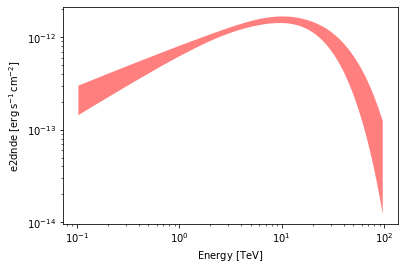

In [5]:
energy_range = [0.1, 100] * u.TeV
fitted_model_3d.spectral_model.plot_error(energy_range, sed_type="e2dnde", facecolor="red", alpha=0.5)

Plotting spectrum...


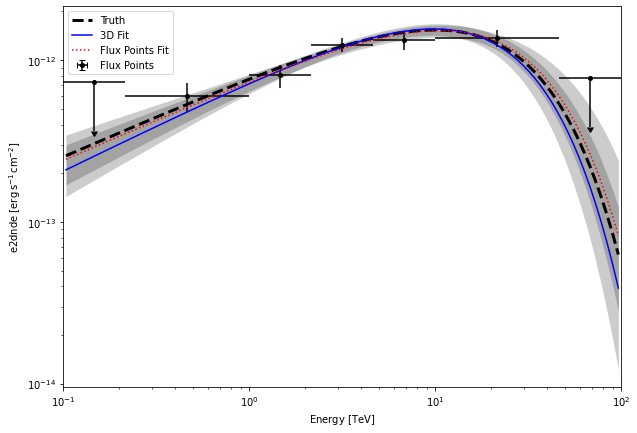

Spectral plot saved to spectral_plot.png


In [6]:
# 6. Plot Spectrum
print("Plotting spectrum...")
plot_spectrum(flux_points, ground_truth_model, fitted_model_3d, fitted_model_fp)


Plotting diagnostics...


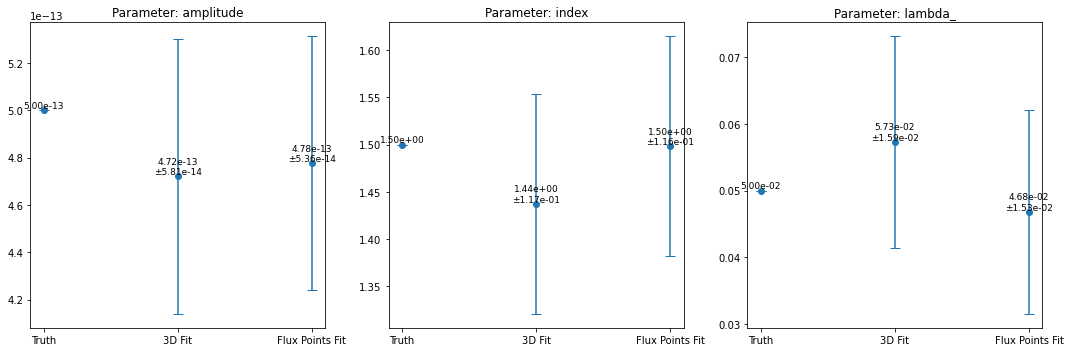

Diagnostic plot saved to diagnostics_plot.png


In [7]:
# 5. Plot Diagnostics
print("Plotting diagnostics...")
plot_diagnostics(ground_truth_model, fitted_model_3d, fitted_model_fp)

Running Nested Sampling for 3D Dataset...
Running nested sampling for 3d...
[ultranest] Sampling 300 live points from prior ...


[ultranest] Explored until L=4e+06  7..4454464.66 [4454463.5684..4454463.5721]*| it/evals=2494/4947 eff=53.6690% N=300 
[ultranest] Likelihood function evaluations: 4949
[ultranest] Writing samples and results to disk ...
[ultranest] Writing samples and results to disk ... done
[ultranest]   logZ = 4.454e+06 +- 0.09927
[ultranest] Effective samples strategy satisfied (ESS = 752.9, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.42, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.10 tail:0.41 total:0.42 required:<0.50
[ultranest] done iterating.

logZ = 4454456.440 +- 0.435
  single instance: logZ = 4454456.440 +- 0.148
  bootstrapped   : logZ = 4454456.399 +- 0.159
  tail           : logZ = +- 0.405
insert order U test : converged: True correlation: inf iterations

    index               : 1.00  │ ▁▁▁▁▁▁▁▂▂▂▂▃▅▅▄▇▅▆▆▇▇▅▆▆▄▃▂▂▂▁▁▁▁▁  ▁ │1.84      1.41 +-

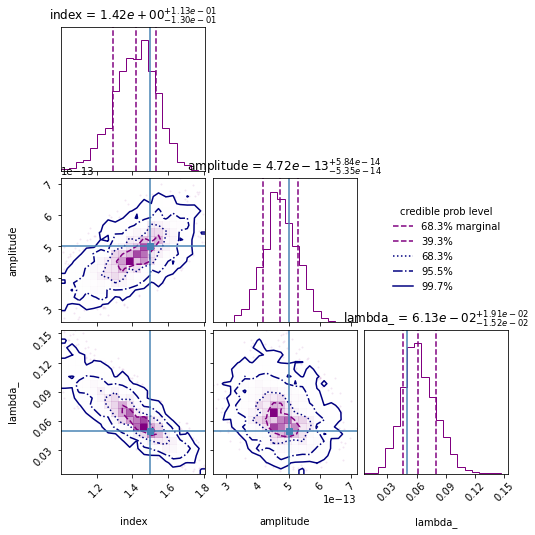

Corner plot saved to corner_plot_3d.png


In [8]:
# 7. Nested Sampling 3D
print("Running Nested Sampling for 3D Dataset...")
ns_result_3d = run_nested_sampling(dataset, model_init, "3d",livepoints=300)
plot_posterior(ns_result_3d, "3d", ground_truth_model)

Running Nested Sampling for Flux Points Dataset...
Running nested sampling for fp...
[ultranest] Sampling 300 live points from prior ...


[ultranest] Explored until L=-3  61 [-3.8214..-3.8200]*| it/evals=2534/4953 eff=54.4595% N=300 0    
[ultranest] Likelihood function evaluations: 4954
[ultranest] Writing samples and results to disk ...
[ultranest] Writing samples and results to disk ... done
[ultranest]   logZ = -11.13 +- 0.09816
[ultranest] Effective samples strategy satisfied (ESS = 743.4, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.42, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.10 tail:0.41 total:0.42 required:<0.50
[ultranest] done iterating.

logZ = -11.103 +- 0.469
  single instance: logZ = -11.103 +- 0.150
  bootstrapped   : logZ = -11.131 +- 0.235
  tail           : logZ = +- 0.406
insert order U test : converged: True correlation: inf iterations

    index               : 1.00  │ ▁ ▁▁▁▁▁▁▁▁▂▂▃▅▅▇▆▆▇▇▆▇▆▆▅▅▅▄▃▂▁▁▁▁▁ ▁ │1.91      1.49 +- 0.13
    amplitude           : 0.

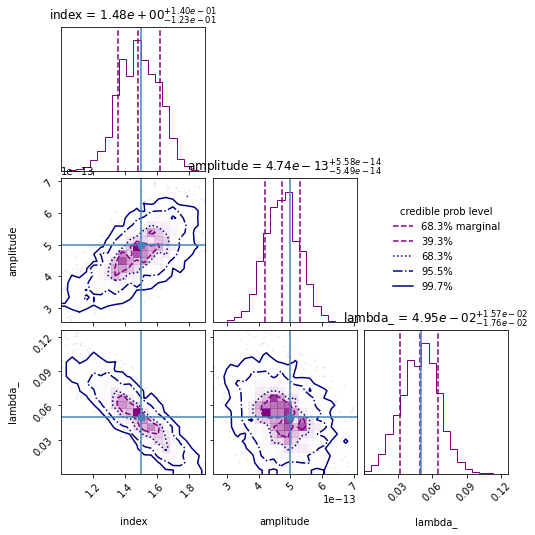

Corner plot saved to corner_plot_fp.png
Script execution completed successfully.


In [9]:
# 8. Nested Sampling Flux Points
# Create FluxPointsDataset first as in fit_flux_points
fp_dataset = FluxPointsDataset(data=flux_points, name="flux-points-dataset",stat_type='distrib')
print("Running Nested Sampling for Flux Points Dataset...")
ns_result_fp = run_nested_sampling(fp_dataset, model_init, "fp",livepoints=300)
plot_posterior(ns_result_fp, "fp", ground_truth_model)
print("Script execution completed successfully.")

Running Nested Sampling for Flux Points Dataset...
Running nested sampling for fp...
[ultranest] Sampling 300 live points from prior ...


[ultranest] Explored until L=-0.6  [-1.6776..-1.6687]*| it/evals=2517/4915 eff=54.5395% N=300       
[ultranest] Likelihood function evaluations: 4915
[ultranest] Writing samples and results to disk ...
[ultranest] Writing samples and results to disk ... done
[ultranest]   logZ = -8.881 +- 0.1086
[ultranest] Effective samples strategy satisfied (ESS = 749.1, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.05 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.42, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.11 tail:0.41 total:0.42 required:<0.50
[ultranest] done iterating.

logZ = -8.877 +- 0.475
  single instance: logZ = -8.877 +- 0.150
  bootstrapped   : logZ = -8.881 +- 0.247
  tail           : logZ = +- 0.406
insert order U test : converged: True correlation: inf iterations

    index               : 1.00  │ ▁ ▁▁▁▁▁▁▁▁▁▁▁▂▁▂▂▅▄▆▇▇▇▇▆▇▇▆▅▄▂▂▁▁▁▁▁ │1.92      1.57 +- 0.12
    amplitude           : 0.0000

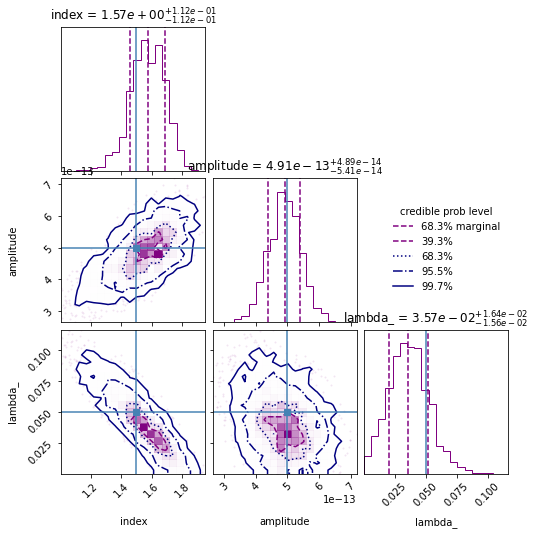

Corner plot saved to corner_plot_fp.png
Script execution completed successfully.


In [10]:
# 8. Nested Sampling Flux Points
# Create FluxPointsDataset first as in fit_flux_points
fp_dataset = FluxPointsDataset(data=flux_points, name="flux-points-dataset",stat_type='chi2')
print("Running Nested Sampling for Flux Points Dataset...")
ns_result_fp_chi2 = run_nested_sampling(fp_dataset, model_init, "fp",livepoints=300)
plot_posterior(ns_result_fp_chi2, "fp", ground_truth_model)
print("Script execution completed successfully.")

In [11]:
ground_truth_dict={}
for p in ground_truth_model.spectral_model.parameters.free_parameters:
    ground_truth_dict[p.name]=p.value
ground_truth_dict

{'index': 1.5, 'amplitude': 5e-13, 'lambda_': 0.05}

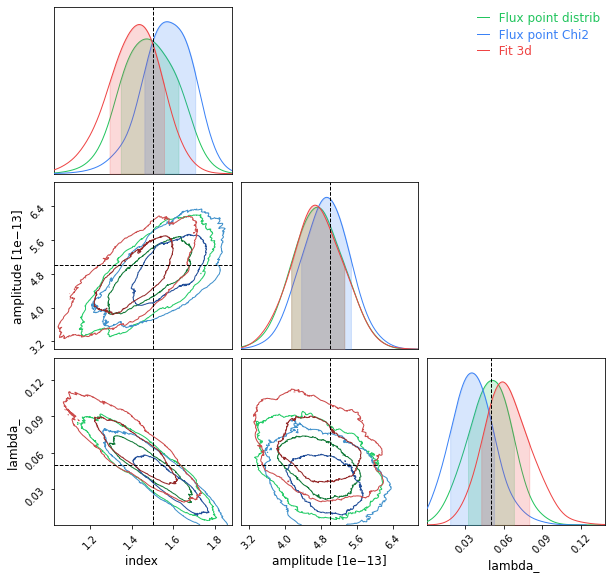

In [12]:
# Uncomment this if you have installed `chainconsumer`.

from chainconsumer import Chain, ChainConfig, ChainConsumer, PlotConfig, Truth, make_sample
from pandas import DataFrame
c = ChainConsumer()
def create_chain(result, name, color="k"):
   return Chain(
       samples=DataFrame(result, columns=["index", "amplitude","lambda_"]),
       name=name,
       color=color,
       smooth=5,
       shade=False,
       linewidth=1.0,
       show_contour_labels=False,
       kde= True
   )
c.add_chain(create_chain(ns_result_fp.samples, "Flux point distrib",color="green"))
c.add_chain(create_chain(ns_result_fp_chi2.samples, "Flux point Chi2",color="blue"))
c.add_chain(create_chain(ns_result_3d.samples, "Fit 3d", color="red"))
c.add_truth(Truth(location=ground_truth_dict, color="k"))

fig = c.plotter.plot()
plt.show()